Training Model on both DHG and SHREC datasets, Testing on DHG

### 1. Imports

In [ ]:
%tensorflow_version 2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
force_use_cpu = False

if force_use_cpu:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
    from tensorflow.keras import backend as K
    print('There should not be a GPU in the following list:', K.tensorflow_backend._get_available_gpus())

In [ ]:
import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
import numpy as np
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, AveragePooling1D, Dropout, Flatten, Lambda, Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 2. Hyperparameters

In [ ]:
# model
dropout_probability = 0.2
duration = 100
n_classes = 14
n_channels = 66  

### 3. Create a model

In [ ]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    # Define model
    model_input = Input(shape=(duration, n_channels))

    # slice into channels
    channel_inputs = Lambda(lambda x: tensorflow.split(x, num_or_size_splits=n_channels, axis=-1))(model_input)

    features = []
    for channel in range(n_channels):
        channel_input = channel_inputs[channel]
        # high branch
        high = Conv1D(filters=8, kernel_size=7, padding='same', activation='relu', input_shape=(100, 1))(channel_input)
        high = AveragePooling1D(pool_size=2)(high)
        high = Conv1D(filters=4, kernel_size=7, padding='same', activation='relu')(high)
        high = AveragePooling1D(pool_size=2)(high)
        high = Conv1D(filters=4, kernel_size=7, padding='same', activation='relu')(high)
        high = Dropout(dropout_probability)(high)
        high = AveragePooling1D(pool_size=2)(high)
        # low branch
        low = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', input_shape=(100, 1))(channel_input)
        low = AveragePooling1D(pool_size=2)(low)
        low = Conv1D(filters=4, kernel_size=3, padding='same', activation='relu')(low)
        low = AveragePooling1D(pool_size=2)(low)
        low = Conv1D(filters=4, kernel_size=3, padding='same', activation='relu')(low)
        low = Dropout(dropout_probability)(low)
        low = AveragePooling1D(pool_size=2)(low)
        # pooling branch
        ap_residual = AveragePooling1D(pool_size=2, input_shape=(100, 1))(channel_input)
        ap_residual = AveragePooling1D(pool_size=2)(ap_residual)
        ap_residual = AveragePooling1D(pool_size=2)(ap_residual)
        # channel output
        channel_output = concatenate([high, low, ap_residual])
        features.append(channel_output)

    features = concatenate(features)
    features = Flatten()(features)
    features = Dense(units=1936, activation='relu')(features)

    model_output = Dense(units=n_classes, activation='softmax')(features)

    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [ ]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

### 4. Load data

In [ ]:
use_shrec_dataset = True

if use_shrec_dataset:

    try:
        # Connect Google Colab instance to Google Drive
        from google.colab import drive
        drive.mount('/gdrive')
        !cp /gdrive/My\ Drive/shrec_data.pckl shrec_data.pckl
    except:
        print("You're not in a Google Colab!")

    def load_data(filepath='./shrec_data.pckl'):
        """
        Returns hand gesture sequences (X) and their associated labels (Y).
        Each sequence has two different labels.
        The first label  Y describes the gesture class out of 14 possible gestures (e.g. swiping your hand to the right).
        The second label Y describes the gesture class out of 28 possible gestures (e.g. swiping your hand to the right with your index pointed, or not pointed).
        """
        file = open(filepath, 'rb')
        data = pickle.load(file, encoding='latin1') 
        file.close()
        return data['x_train'], data['x_test'], data['y_train_14'], data['y_train_28'], data['y_test_14'], data['y_test_28']

    x1_train, x1_test, y1_train_14, y1_train_28, y1_test_14, y1_test_28 = load_data('shrec_data.pckl')
    y1_train_14, y1_test_14 = numpy.array(y1_train_14), numpy.array(y1_test_14)
    y1_train_28, y1_test_28 = numpy.array(y1_train_28), numpy.array(y1_test_28)
    if n_classes == 14:
        y_train_shrec = y1_train_14
        y_test_shrec = y1_test_14
    elif n_classes == 28:
        y_train_shrec = y1_train_28
        y_test_shrec = y1_test_28


Mounted at /gdrive


In [ ]:

use_dhg_dataset = True

if use_dhg_dataset:

    try:
        # Connect Google Colab instance to Google Drive
        from google.colab import drive
        drive.mount('/gdrive',force_remount=True)
        !cp /gdrive/My\ Drive/dhg_data.pckl dhg_data.pckl
    except:
        print("You're not in a Google Colab!")

    def load_data(filepath='./dhg_data.pckl'):
        """
        Returns hand gesture sequences (X) and their associated labels (Y).
        """
        file = open(filepath, 'rb')
        data = pickle.load(file, encoding='latin1') 
        file.close()
        return data['x_train'], data['x_test'], data['y_train_14'], data['y_train_28'], data['y_test_14'], data['y_test_28']

    x2_train, x2_test, y2_train_14, y2_train_28, y2_test_14, y2_test_28 = load_data('dhg_data.pckl')
    y2_train_14, y2_test_14 = numpy.array(y2_train_14), numpy.array(y2_test_14)
    y2_train_28, y2_test_28 = numpy.array(y2_train_28), numpy.array(y2_test_28)
    if n_classes == 14:
        y_train_dhg = y2_train_14
        y_test_dhg = y2_test_14
    elif n_classes == 28:
        y_train_dhg = y2_train_28
        y_test_dhg = y2_test_28


Mounted at /gdrive


In [ ]:
# Cross checking the data for DHG
if y_train_dhg.min() > 0:
  y_train_dhg = y_train_dhg - 1
if y_test_dhg.min() > 0:
  y_test_dhg = y_test_dhg - 1

# Transform the labels to one-hot encoding for the cross-entropy loss
y_train_dhg = to_categorical(y_train_dhg, num_classes=n_classes)
y_test_dhg = to_categorical(y_test_dhg, num_classes=n_classes)

In [ ]:
# Cross checking the data for SHREC
if y_train_shrec.min() > 0:
  y_train_shrec = y_train_shrec - 1
if y_test_shrec.min() > 0:
  y_test_shrec = y_test_shrec - 1

# Transform the labels to one-hot encoding for the cross-entropy loss
y_train_shrec = to_categorical(y_train_shrec, num_classes=n_classes)
y_test_shrec = to_categorical(y_test_shrec, num_classes=n_classes)

### 5. Training the model

In [ ]:
# Optimizer's Learning Rate
learning_rate = 0.001
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Training the model
history = model.fit(x2_train, y_train_dhg,epochs=50, batch_size=28)

Epoch 1/50
70/70 [==============================] - 72s 102ms/step - loss: 3.1589 - accuracy: 0.0928
Epoch 2/50
70/70 [==============================] - 7s 103ms/step - loss: 2.3862 - accuracy: 0.2609
Epoch 3/50
70/70 [==============================] - 7s 103ms/step - loss: 1.7726 - accuracy: 0.4199
Epoch 4/50
70/70 [==============================] - 7s 101ms/step - loss: 1.4501 - accuracy: 0.5163
Epoch 5/50
70/70 [==============================] - 7s 102ms/step - loss: 1.2634 - accuracy: 0.5686
Epoch 6/50
70/70 [==============================] - 7s 103ms/step - loss: 1.1836 - accuracy: 0.6177
Epoch 7/50
70/70 [==============================] - 7s 103ms/step - loss: 0.9889 - accuracy: 0.6901
Epoch 8/50
70/70 [==============================] - 7s 104ms/step - loss: 0.8657 - accuracy: 0.7070
Epoch 9/50
70/70 [==============================] - 7s 104ms/step - loss: 0.8254 - accuracy: 0.7317
Epoch 10/50
70/70 [==============================] - 7s 103ms/step - loss: 0.7876 - accuracy: 0.724

In [ ]:
history = model.fit(x1_train, y_train_shrec,epochs=50, batch_size=28)


Epoch 1/50
70/70 [==============================] - 7s 103ms/step - loss: 1.8726 - accuracy: 0.6168
Epoch 2/50
70/70 [==============================] - 7s 104ms/step - loss: 0.5838 - accuracy: 0.8255
Epoch 3/50
70/70 [==============================] - 7s 103ms/step - loss: 0.4038 - accuracy: 0.8816
Epoch 4/50
70/70 [==============================] - 8s 110ms/step - loss: 0.3109 - accuracy: 0.9112
Epoch 5/50
70/70 [==============================] - 7s 105ms/step - loss: 0.2783 - accuracy: 0.9194
Epoch 6/50
70/70 [==============================] - 7s 104ms/step - loss: 0.2259 - accuracy: 0.9316
Epoch 7/50
70/70 [==============================] - 7s 103ms/step - loss: 0.2157 - accuracy: 0.9362
Epoch 8/50
70/70 [==============================] - 7s 103ms/step - loss: 0.1649 - accuracy: 0.9490
Epoch 9/50
70/70 [==============================] - 7s 103ms/step - loss: 0.1678 - accuracy: 0.9526
Epoch 10/50
70/70 [==============================] - 7s 103ms/step - loss: 0.1348 - accuracy: 0.9597

In [ ]:
new_var2= model.predict(x2_test)
try_new2=confusion_matrix( y_test_dhg.argmax(axis=1),new_var2.argmax(axis=1))
matrix_new2 = classification_report( y_test_dhg.argmax(axis=1),new_var2.argmax(axis=1))
print(matrix_new2)

              precision    recall  f1-score   support

           0       0.52      0.17      0.26        64
           1       0.56      0.64      0.59        69
           2       0.81      0.21      0.33        62
           3       0.24      0.75      0.36        56
           4       0.60      0.40      0.48        53
           5       0.43      0.53      0.47        60
           6       0.67      0.11      0.19        54
           7       0.38      0.51      0.43        68
           8       0.12      0.04      0.06        53
           9       0.22      0.23      0.22        69
          10       0.78      0.52      0.62        60
          11       0.63      0.58      0.61        57
          12       0.50      0.18      0.27        60
          13       0.37      0.87      0.52        55

    accuracy                           0.41       840
   macro avg       0.49      0.41      0.39       840
weighted avg       0.49      0.41      0.39       840



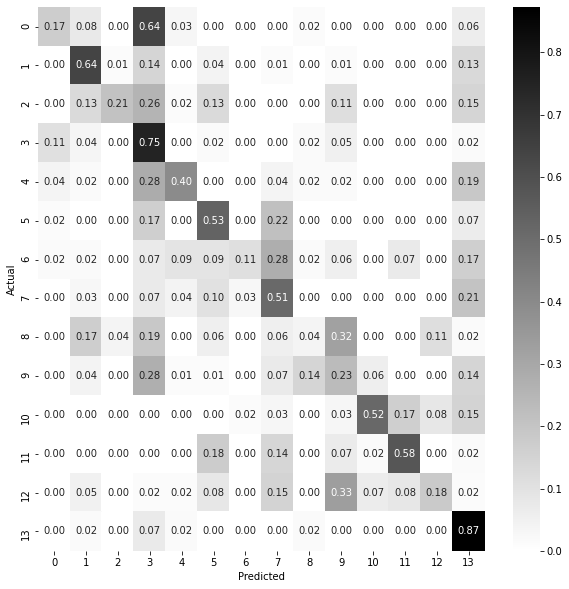

In [ ]:
try_new_normal2 = try_new2.astype('float') / try_new2.sum(axis=1)[:, numpy.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(try_new_normal2, annot=True, fmt='.2f', cbar=True,cmap=plt.cm.binary)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

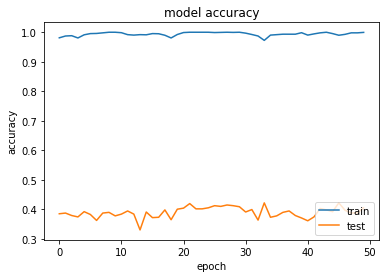

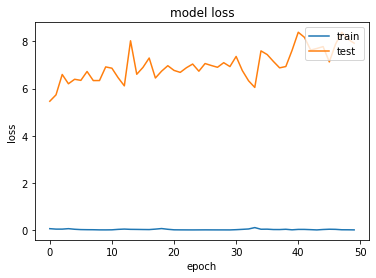

In [ ]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
_, train_accuracy = model.evaluate(x1_train, y_train_shrec)
_, test_accuracy = model.evaluate(x2_test, y_test_dhg)

27/27 [==============================] - 1s 40ms/step - loss: 5.3822 - accuracy: 0.4107


In [ ]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 100.00%
Accuracy on test set: 40.48%


This code has been referenced from 

```
@inproceedings{devineau2018deep,
  title={Deep learning for hand gesture recognition on skeletal data},
  author={Devineau, Guillaume and Moutarde, Fabien and Xi, Wang and Yang, Jie},
  booktitle={2018 13th IEEE International Conference on Automatic Face \& Gesture Recognition (FG 2018)},
  pages={106--113},
  year={2018},
  organization={IEEE}
}
```
